# Forward Problem

In [3]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial

## Constants

In [4]:
L = 1.
NX = NY = 128
X_START = 0.
X_END = L
Y_START = 0.
Y_END = L

## Domain

In [5]:
x = jnp.linspace(X_START, X_END, NX + 1)
y = jnp.linspace(Y_START, Y_END, NY + 1)
X, Y = jnp.meshgrid(x, y)

In [6]:
dx = x[1] - x[0]
dy = y[1] - y[0]

## Source Term ($f$) and Solution ($u$) Functions

In [7]:
u = (lambda x, y: jnp.sin(2.*jnp.pi*x) * jnp.sin(2.*jnp.pi*y) + (1./16.**2) * jnp.sin(32.*jnp.pi*x) * jnp.sin(32.*jnp.pi*y))
f = (lambda x, y: -8 * jnp.pi**2 * jnp.sin(2*jnp.pi*x) * jnp.sin(2*jnp.pi*y) - 8 * jnp.pi**2 * jnp.sin(32.*jnp.pi*x) * jnp.sin(32.*jnp.pi*y))

##  Source Term and Solution

In [8]:
U = u(X, Y)
F = f(X, Y)

### Specifics of the Spectral solver

In [9]:
hx = 2. * jnp.pi / (NX * dx)

In [10]:
m_arr = jnp.empty(NX)
m_arr = m_arr.at[jnp.arange(0, int(NX/2))].set(hx * jnp.arange(0, int(NX/2))) 
m_arr = m_arr.at[jnp.arange(int(NX/2), NX)].set(hx * jnp.arange(-int(NX/2), 0))
n_arr = jnp.copy(m_arr)

In [11]:
u_tilda_den = lambda m, n: (-(m**2 + n**2))
den_jax = jax.vmap(jax.vmap(u_tilda_den, in_axes=(0, None)), in_axes=(None, 0))(m_arr, n_arr)

In [12]:
den_jax = den_jax.at[0,0].set(jnp.finfo(float).eps)

## Solver Function

In [13]:
@jax.jit
def poisson_fft_spectral_direct_solver(F, den):
    U_final = jnp.zeros_like(F)
    F_tilda = jnp.fft.fftn(F[:-1, :-1].astype(complex))
    F_tilda = F_tilda.at[0,0].set(complex(0,0))    
    U_tilda = F_tilda/den
    U_final = U_final.at[:-1, :-1].set(jnp.real(jnp.fft.ifftn(U_tilda)))
    U_final = U_final.at[-1,:].set(U_final[0, :]) # periodic boundary condition handling
    return U_final.at[:,-1].set(U_final[:, 0]) # periodic boundary condition handling

## Validating the solver

In [14]:
U_numerical = poisson_fft_spectral_direct_solver(F, den_jax)

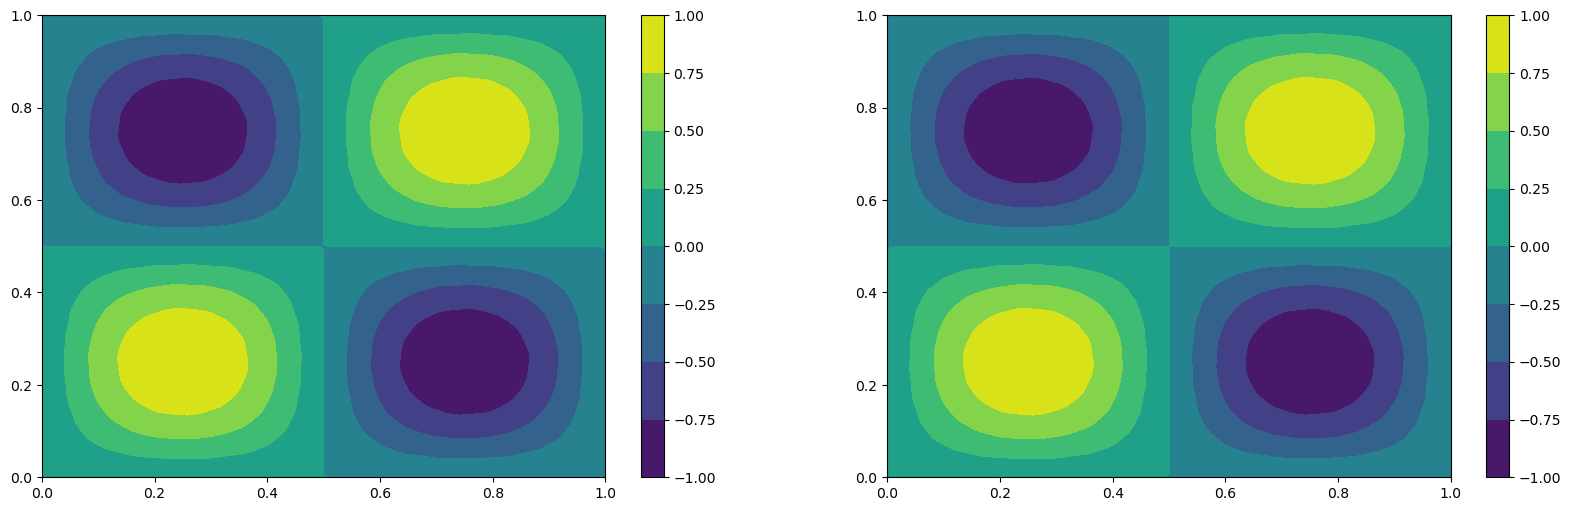

In [15]:
fig, axs = plt.subplots(1,2, figsize=(20,6))
num = axs[0].contourf(X, Y, U_numerical)
gt = axs[1].contourf(X, Y, U)
fig.colorbar(num)
fig.colorbar(gt)
plt.show()

# Inverse Problem
### Technique: model $f$ using Neural Nets 

In [16]:
import haiku as hk
# from jax.flatten_util import ravel_pytree
# from jax.scipy.optimize import minimize
import optax

### Inputs of the Neural Nets: the x and y coordinate of the grid

In [17]:
data = jax.vmap\
       (jax.vmap(lambda i, j: jnp.asarray((x[i], y[j])),\
       in_axes=(None, 0)), in_axes=(0, None))\
       (jnp.arange(NX+1),jnp.arange(NX+1))

### Arguments for generating parameters of the Neural Nets

In [18]:
rng_key = jax.random.PRNGKey(42)
# output_sizes = jnp.asarray((4, 4, 1))
dummy = jnp.expand_dims(jnp.expand_dims(jnp.asarray((1., 1.)), 0), 1)

### Implemenation of MLP nets

In [19]:
class InverseSolverNN(hk.Module):
    def __init__(self, name: str | None = None):
        super().__init__(name=name)
        self.net = hk.Sequential([
            hk.Linear(10), jax.nn.selu,
            hk.Linear(10), jax.nn.selu,
            hk.Linear(1)
        ])
    
    def __call__(self, x):
        return self.net(x).mean(axis=2)
    
def inverse_solver_forward_pass(x: jax.Array):
    model = InverseSolverNN()
    return model(x)

In [20]:
transformed_inverse_solver = hk.transform(inverse_solver_forward_pass)

### Generating parameters using init, and transforming apply function 

In [21]:
params_init = transformed_inverse_solver.init(rng_key, dummy)
#params_flatten_init, params_unravel_pytree = ravel_pytree(params_init)

In [22]:
@jax.jit
def predict(params, data):
    return transformed_inverse_solver.apply(params, None, data) 

## Loss function

In [23]:
def scalar_loss(params, U_num, den, data):
    # params = params_unravel_pytree(params_flatten)
    F_pred = predict(params, data)
    U_num_pred = poisson_fft_spectral_direct_solver(F_pred, den)
    return optax.l2_loss(U_num_pred, U_num).mean() #jnp.mean((U_num - U_num_pred)**2)

## Fit function for optimizing parameters

In [24]:
# optimized_flatten_params = minimize(scalar_loss, params_flatten_init,\
#                            (U_numerical, den_jax, data), tol=1e-6,\
#                             method="BFGS")

In [25]:
def fit(params: optax.Params, optimizer:optax.GradientTransformation, U_num, den, data, total_steps=10000):
    opt_state = optimizer.init(params)
    
    @jax.jit
    def step(params, opt_state, U_num, den, data):
        loss_val, grads = jax.value_and_grad(scalar_loss)(params, U_num, den, data)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss_val
    
    for i in range(total_steps):
        params, opt_state, loss_val = step(params, opt_state, U_num, den, data)
        if i % 5000 == 0:
            print(f"Loss value at iteration {i} is {loss_val}")
    
    return params

In [26]:
optimizer = optax.adam(learning_rate=1e-2)
opt_params = fit(params_init, optimizer, U_numerical, den_jax, data, 10_000)

Loss value at iteration 0 is 0.12305712699890137
Loss value at iteration 5000 is 7.55667788325809e-05


## Comparing the results

In [27]:
#params = params_unravel_pytree(optimized_flatten_params.x)
F_pred = predict(opt_params, data)
U_num_pred = poisson_fft_spectral_direct_solver(F_pred, den_jax)

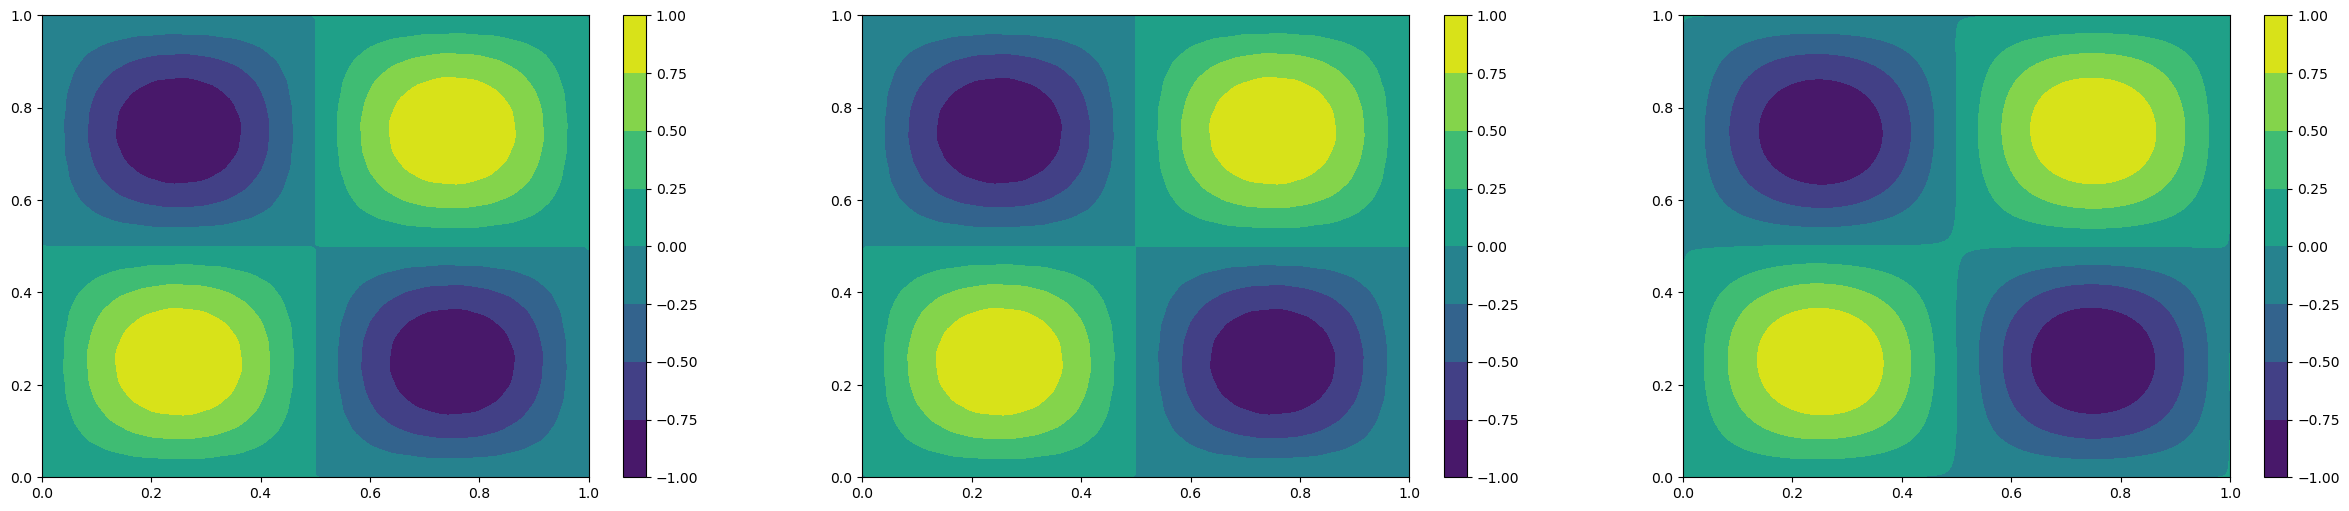

In [28]:
fig, axs = plt.subplots(1,3, figsize=(30,6))
num = axs[0].contourf(X, Y, U_numerical)
gt = axs[1].contourf(X, Y, U)
rev = axs[2].contourf(X, Y, U_num_pred)
fig.colorbar(num)
fig.colorbar(gt)
fig.colorbar(rev)
plt.show()

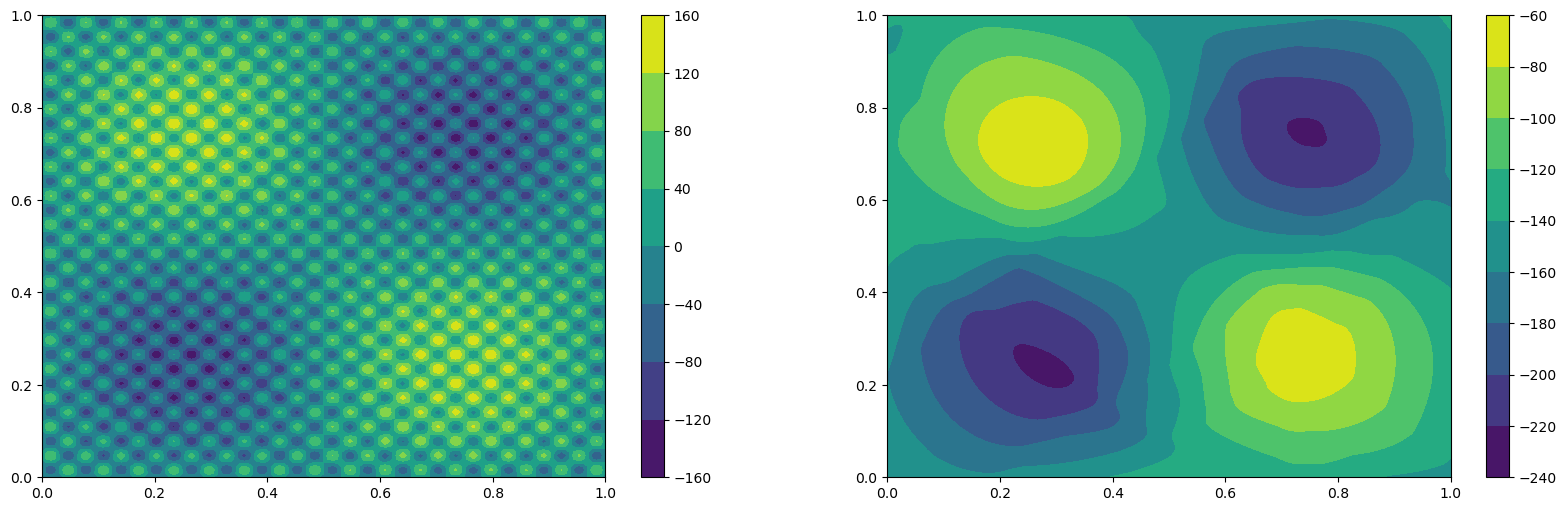

In [29]:
fig, axs = plt.subplots(1,2, figsize=(20,6))
gt = axs[0].contourf(X, Y, F)
rev = axs[1].contourf(X, Y, F_pred)
fig.colorbar(gt)
fig.colorbar(rev)
plt.show()

# Errors faced with haiku MLP

In [30]:
from jax.flatten_util import ravel_pytree
from jax.scipy.optimize import minimize

In [31]:
output_sizes = jnp.asarray((10, 10, 1))

In [32]:
class InverseSolverNN_MLP(hk.Module):
    def __init__(self, output_sizes: jax.Array = output_sizes, name: str | None = None):
        super().__init__(name=name)
        self.net = hk.nets.MLP(output_sizes)
    
    def __call__(self, x):
        return self.net(x).mean(axis=2)
    
def inverse_solver_forward_pass_MLP(x: jax.Array):
    model = InverseSolverNN_MLP()
    return model(x)

In [33]:
transformed_inverse_solver_MLP = hk.transform(inverse_solver_forward_pass_MLP)

In [34]:
params_init_MLP = transformed_inverse_solver_MLP.init(rng_key, dummy)

In [35]:
res = jax.jit(transformed_inverse_solver_MLP.apply)(params_init_MLP, None, data)

ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected: traced array with shape bool[].
The problem arose with the `bool` function. 
The error occurred while tracing the function apply_fn at /home/mparikh2/miniconda3/envs/jaxenv/lib/python3.10/site-packages/haiku/_src/transform.py:179 for jit. This value became a tracer due to JAX operations on these lines:

  operation a:i32[] b:i32[] c:i32[] = pjit[
  jaxpr={ lambda ; d:i32[3]. let
      e:i32[1] = slice[limit_indices=(1,) start_indices=(0,) strides=(1,)] d
      f:i32[] = squeeze[dimensions=(0,)] e
      g:i32[1] = slice[limit_indices=(2,) start_indices=(1,) strides=(1,)] d
      h:i32[] = squeeze[dimensions=(0,)] g
      i:i32[1] = slice[limit_indices=(3,) start_indices=(2,) strides=(1,)] d
      j:i32[] = squeeze[dimensions=(0,)] i
    in (f, h, j) }
  name=_unstack
] k
    from line /tmp/ipykernel_6217/154983351.py:4 (__init__)

  operation a:i32[] = convert_element_type[new_dtype=int32 weak_type=False] b
    from line /tmp/ipykernel_6217/154983351.py:7 (__call__)

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError